In [2]:
from sklearn.metrics import precision_recall_curve, auc
import pandas as pd
import pickle
import seaborn as sns

def pr_auc_score(y_true, probas_pred):
    precision, recall, _ = precision_recall_curve(y_true=y_true, probas_pred=probas_pred)
    return auc(recall, precision)

In [3]:
df_b3db_kc = pd.read_csv("b3db_kc_split_descriptors.tsv", sep="\t")
df_b3db_kc['BBB_numeric'] = df_b3db_kc['BBB+/BBB-'].map({'BBB+': 1, 'BBB-': 0})
df_train = df_b3db_kc[df_b3db_kc.split == "training"].copy().reset_index(drop=1)
df_test = df_b3db_kc[df_b3db_kc.split == "test"].copy().reset_index(drop=1)
print(f"Read {len(df_b3db_kc)} records, {len(df_train)} in training, and {len(df_test)} in test splits.")


df_train_features = df_train.drop(columns=["inchi", "names", "iupac_name", "smiles", "cid", "record_ids", "logBB", "logBB_group", "BBB+/BBB-",  "BBB+/BBB-_group", "BBB_numeric", "split"]) #, "murcko_scaffold_grouped"])
df_train_features_desc2D_chemaxon = df_train_features[[c for c in list(df_train_features) if c.startswith("chemaxon") or c.startswith("desc2D")]]
df_train_features_ecfp_count = df_train_features[[c for c in list(df_train_features) if c.startswith("ecfp")]]
df_train_features_maccs = df_train_features[[c for c in list(df_train_features) if c.startswith("maccs")]]


Read 3322 records, 2650 in training, and 672 in test splits.


In [4]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import RFE, SequentialFeatureSelector
from xgboost import XGBClassifier

from sklearn.feature_selection import mutual_info_classif

def get_correlated_features(_df, feature, threshold=0.9):
    cor_mtx = _df.corr()
    correlated = []
    for c in list(cor_mtx.columns):
        if c != feature:
            c_a = abs(cor_mtx.loc[feature, c])
            if c_a > threshold:
                # print(c, feature, c_a)
                correlated.append(c)
    return correlated          

def get_feature_rank_mutual_information(X, y):
    mutual_info_scores = mutual_info_classif(X, y, random_state=42)
    mutual_info_scores_series = pd.Series(mutual_info_scores, index=X.columns)
    return mutual_info_scores_series.sort_values(ascending=False)
    
def get_feature_rank_xgboost_classification(X, y):
    model = XGBClassifier(random_state=42)
    model.fit(X, y)
    return pd.Series(model.feature_importances_, index=X.columns).sort_values(ascending=False)

# def get_feature_rank_random_forest_classification(X, y, n_features_to_select=None):
#     model = RandomForestClassifier(random_state=42)
#     #rfe = RFE(estimator=model, n_features_to_select=n_features_to_select) # None implies half the features get selected
#     #rfe.fit(X, y)
#     # return pd.Series(rfe.ranking_, index=X.columns)
#     sfs = SequentialFeatureSelector(estimator=model, n_jobs=-1, n_features_to_select=n_features_to_select)
#     sfs.fit(X, y)
#     z = pd.Series(sfs.get_support(), index=X.columns)
#     return z[z == True]
#     
# def get_feature_rank_logistic_regression(X, y, n_features_to_select=None):
#     model = LogisticRegression(random_state=42, max_iter=1000)
#     #rfe = RFE(estimator=model, n_features_to_select=n_features_to_select) # None implies half the features get selected
#     #rfe.fit(X, y)
#     # return pd.Series(rfe.ranking_, index=X.columns)
#     sfs = SequentialFeatureSelector(estimator=model, n_jobs=-1, n_features_to_select=n_features_to_select)
#     sfs.fit(X, y)
#     z = pd.Series(sfs.get_support(), index=X.columns)
#     return z[z == True]


# def get_filtered_ranked_features(X, y):
#     """
#     This method first extracts the features that are both present in top 50% based on both mutual information and top performers under XGBoost classification. It then ranks the remaining features using Recursive Feature Elimination wrapper using Random Forest model.
#     
#     This method relies on both boosted algorithms that performed well during the train / test split selection.
#     """
#     _n_mut_inf_xgboost_feats = int(len(list(X)) / 2)
#     _fs_mut_inf = get_feature_rank_mutual_information(X, y)
#     _fs_xgboost = get_feature_rank_xgboost_classification(X, y)
#     _s_fs = set(_fs_mut_inf.index[:_n_mut_inf_xgboost_feats]) & set(_fs_xgboost.index[:_n_mut_inf_xgboost_feats])
#     fs_ranking = get_feature_rank_random_forest_classification(X[[f for f in list(X) if f in _s_fs]], y, n_features_to_select=1)
#     return fs_ranking



In [5]:
CNS_MPO_FEATURES = ["desc2D_TPSA", "desc2D_MolWt", "desc2D_NumHDonors", "chemaxon_logp", "chemaxon_logd", "chemaxon_pka_b"]
CORRELATION_THRESHOLD = 0.8

_selected = CNS_MPO_FEATURES + ["desc2D_NumHAcceptors", "desc2D_HeavyAtomCount"]
_correlated = set()
for _f in _selected + [c for c in get_feature_rank_mutual_information(df_train_features_desc2D_chemaxon, df_train["BBB_numeric"]).index if c not in _selected]:    
    if _f not in _correlated:
        if _f not in _selected:
            _selected.append(_f)
        _correlated = _correlated | set(get_correlated_features(df_train_features_desc2D_chemaxon, _f, threshold=CORRELATION_THRESHOLD))
df_train_features_desc2D_chemaxon_filtered = df_train_features_desc2D_chemaxon[_selected]
print(f"Removed {len(list(df_train_features_desc2D_chemaxon)) - len(list(df_train_features_desc2D_chemaxon_filtered))} desc2D+ChemAxon correlated features (threshold: {CORRELATION_THRESHOLD}), {len(list(df_train_features_desc2D_chemaxon_filtered))} remaining")
#mutget_feature_rank_mutual_information(df_train_features_desc2D_chemaxon, df_train["BBB_numeric"])

Removed 60 desc2D+ChemAxon correlated features (threshold: 0.8), 151 remaining


In [6]:
SIMPLE_FILTERED_FEATURES = [
    'desc2D_TPSA',
    'desc2D_NumHDonors',
    'chemaxon_logp',
    'chemaxon_logd',
    'chemaxon_pka_b',
    'desc2D_NumHAcceptors',
    'desc2D_HeavyAtomCount',
    'desc2D_MinPartialCharge',
    'desc2D_MaxPartialCharge',
    'desc2D_qed',
    'desc2D_MinEStateIndex',
    'desc2D_HallKierAlpha',
    'desc2D_MaxEStateIndex',
    'desc2D_Kappa3',
    'desc2D_Ipc',
    'desc2D_FractionCSP3',
    'desc2D_NumSaturatedHeterocycles',
    'desc2D_Chi4v',
    'desc2D_MinAbsEStateIndex',
    'desc2D_NumRotatableBonds',
    'desc2D_BalabanJ',
    'desc2D_RingCount',
    'desc2D_NumAmideBonds',
    'desc2D_NumAromaticHeterocycles',
    'desc2D_NumSpiroAtoms',
    'desc2D_NumSaturatedRings',
    'desc2D_NumAtomStereoCenters',
    'desc2D_NumBridgeheadAtoms',
    'desc2D_NumUnspecifiedAtomStereoCenters',
    'desc2D_NumRadicalElectrons',
    'desc2D_NumAromaticRings',
]
EXTENDED_FILTERED_FEATURES = SIMPLE_FILTERED_FEATURES + [
    'desc2D_BCUT2D_MWHI',
    'desc2D_SMR_VSA1',
    'desc2D_SMR_VSA10',
    'desc2D_PEOE_VSA1',
    'desc2D_BCUT2D_MRLOW',
    'desc2D_SlogP_VSA2',
    'desc2D_PEOE_VSA10',
    'desc2D_VSA_EState3',
    'desc2D_SlogP_VSA3',
    'desc2D_SMR_VSA5',
    'desc2D_BCUT2D_MWLOW',
    'desc2D_EState_VSA4',
    'desc2D_SlogP_VSA6',
    'desc2D_EState_VSA2',
    'desc2D_PEOE_VSA8',
    'desc2D_VSA_EState2',
    'desc2D_BCUT2D_CHGLO',
    'desc2D_EState_VSA9',
    'desc2D_PEOE_VSA9',
    'desc2D_PEOE_VSA6',
    'desc2D_EState_VSA3',
    'desc2D_EState_VSA8',
    'desc2D_SMR_VSA6',
    'desc2D_SlogP_VSA1',
    'desc2D_EState_VSA5',
    'desc2D_VSA_EState9',
    'desc2D_EState_VSA6',
    'desc2D_VSA_EState5',
    'desc2D_PEOE_VSA7',
    'desc2D_fr_COO2',
    'desc2D_VSA_EState4',
    'desc2D_SMR_VSA3',
    'desc2D_VSA_EState1',
    'desc2D_VSA_EState7',
    'desc2D_PEOE_VSA14',
    'desc2D_SMR_VSA4',
    'desc2D_PEOE_VSA11',
    'desc2D_PEOE_VSA3',
    'desc2D_SlogP_VSA10',
    'desc2D_fr_halogen',
    'desc2D_FpDensityMorgan2',
    'desc2D_VSA_EState10',
    'desc2D_PEOE_VSA13',
    'desc2D_fr_Ar_NH',
    'desc2D_Alerts',
    'desc2D_EState_VSA7',
    'desc2D_PEOE_VSA4',
    'desc2D_PEOE_VSA5',
    'desc2D_fr_sulfide',
    'desc2D_fr_para_hydroxylation',
    'desc2D_PEOE_VSA12',
    'desc2D_fr_ketone_Topliss',
    'desc2D_fr_Ar_OH',
    'desc2D_fr_N_O',
    'desc2D_fr_allylic_oxid',
    'desc2D_fr_lactam',
    'desc2D_fr_aldehyde',
    'desc2D_VSA_EState8',
    'desc2D_SMR_VSA9',
    'desc2D_fr_sulfone',
    'desc2D_fr_Al_OH_noTert',
    'desc2D_fr_epoxide',
    'desc2D_fr_thiazole',
    'desc2D_SlogP_VSA8',
    'desc2D_SlogP_VSA11',
    'desc2D_fr_NH1',
    'desc2D_EState_VSA11',
    'desc2D_fr_NH2',
    'desc2D_fr_pyridine',
    'desc2D_fr_quatN',
    'desc2D_fr_azo',
    'desc2D_fr_isothiocyan',
    'desc2D_fr_nitro_arom_nonortho',
    'desc2D_fr_Ndealkylation2',
    'desc2D_fr_barbitur',
    'desc2D_fr_sulfonamd',
    'desc2D_fr_nitroso',
    'desc2D_fr_methoxy',
    'desc2D_fr_aniline',
    'desc2D_fr_urea',
    'desc2D_SMR_VSA2',
    'desc2D_fr_diazo',
    'desc2D_fr_phos_ester',
    'desc2D_fr_ether',
    'desc2D_fr_SH',
    'desc2D_fr_aryl_methyl',
    'desc2D_fr_isocyan',
    'desc2D_fr_prisulfonamd',
    'desc2D_fr_azide',
    'desc2D_SlogP_VSA9',
    'desc2D_fr_piperdine',
    'desc2D_fr_imidazole',
    'desc2D_fr_priamide',
    'desc2D_fr_ArN',
    'desc2D_fr_amidine',
    'desc2D_fr_Ndealkylation1',
    'desc2D_fr_oxime',
    'desc2D_fr_morpholine',
    'desc2D_fr_benzodiazepine',
    'desc2D_fr_Imine',
    'desc2D_fr_guanido',
    'desc2D_fr_alkyl_carbamate',
    'desc2D_fr_bicyclic',
    'desc2D_fr_tetrazole',
    'desc2D_fr_dihydropyridine',
    'desc2D_fr_ester',
    'desc2D_fr_unbrch_alkane',
    'desc2D_SMR_VSA8',
    'desc2D_fr_thiophene',
    'desc2D_SlogP_VSA7',
    'desc2D_fr_thiocyan',
    'desc2D_fr_nitro',
    'desc2D_fr_term_acetylene',
    'desc2D_fr_Ar_COO',
    'desc2D_fr_hdrzine',
    'desc2D_fr_hdrzone',
    'desc2D_fr_piperzine',
    'desc2D_fr_NH0',
    'desc2D_fr_HOCCN',
    'desc2D_fr_lactone',
    'desc2D_fr_C_S',
    'desc2D_fr_oxazole',
    'desc2D_fr_furan'
]

In [7]:
# nmax=int(len(list(df_train_features)) / 2)
# #nmax = 1000
# features_selection_mutual_information = get_feature_rank_mutual_information(df_train_features, df_train["BBB_numeric"])
# features_selection_xgboost_classification = get_feature_rank_xgboost_classification(df_train_features, df_train["BBB_numeric"])
# _s_features_m_inf_and_xgboost = set(features_selection_mutual_information.index[:nmax]) & set(features_selection_xgboost_classification.index[:nmax])
# #print(len(_s_features_m_inf_and_xgboost))
# features_rf_ranking = get_feature_rank_random_forest_classification(df_train_features[[f for f in list(df_train_features) if f in _s_features_m_inf_and_xgboost]], df_train["BBB_numeric"], n_features_to_select=1)

In [8]:
# get_filtered_ranked_features(df_train_features_ecfp_count, df_train["BBB_numeric"])
# get_feature_rank_xgboost_classification(df_train_features_maccs, df_train["BBB_numeric"])
#get_feature_rank_xgboost_classification(df_b3db_kc[[c for c in list(df_b3db_kc) if c.startswith("maccs")]], df_b3db_kc["BBB_numeric"])

In [9]:
# from molfeat.trans.fp import FPVecTransformer
# from utils import smiles_to_mol
# df_b3db_kc["mol"] = df_b3db_kc.smiles.apply(smiles_to_mol)
# transformer = FPVecTransformer(kind="maccs", dtype=float, n_jobs=16, verbose=True)  
# _df_desc = pd.DataFrame(transformer(df_b3db_kc["mol"]), columns=transformer.columns)
# get_feature_rank_xgboost_classification(_df_desc, df_b3db_kc["BBB_numeric"])
# df_b3db = pd.read_csv("B3DB/B3DB/B3DB_classification.tsv", sep="\t")
# df_b3db["mol"] = df_b3db.SMILES.apply(smiles_to_mol)
# df_b3db['BBB_numeric'] = df_b3db['BBB+/BBB-'].map({'BBB+': 1, 'BBB-': 0})
# _df_desc_b3db = pd.DataFrame(transformer(df_b3db["mol"]), columns=transformer.columns)
# get_feature_rank_xgboost_classification(_df_desc_b3db, df_b3db["BBB_numeric"])

In [10]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, confusion_matrix, \
    classification_report
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.model_selection import cross_validate, StratifiedGroupKFold

df_test_features = df_test.drop(columns=["inchi", "names", "iupac_name", "smiles", "cid", "record_ids", "logBB", "logBB_group", "BBB+/BBB-",  "BBB+/BBB-_group", "BBB_numeric", "split", "murcko_scaffold_grouped"])
df_test_features_desc2D_chemaxon = df_test_features[[c for c in list(df_test_features) if c.startswith("chemaxon") or c.startswith("desc2D")]]
df_test_features_ecfp_count = df_test_features[[c for c in list(df_test_features) if c.startswith("ecfp")]]
df_test_features_maccs = df_test_features[[c for c in list(df_test_features) if c.startswith("maccs")]]


def evaluate_train(model, X_train, X_groups, y_train):
    return cross_validate(
        model, X_train, y_train,
        groups=X_groups,
        scoring=["roc_auc", "balanced_accuracy", "precision", "recall", "accuracy", "f1"],
        cv=StratifiedGroupKFold(5, shuffle=True, random_state=42),
        verbose=1,
        return_indices=True
    )


def evaluate_test(_model, X_test, y_test):
    y_pred = _model.predict(X_test)
    y_prob = _model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
    return {
        "roc_auc": roc_auc_score(y_test, y_prob),
        "pr_auc": pr_auc_score(y_test, y_prob),
        "balanced_accuracy": balanced_accuracy_score(y_test, y_pred),
        "accuracy": accuracy_score(y_test, y_pred),
    }


def display_test_evaluation(_model, X_test, y_test):
    y_pred = _model.predict(X_test)
    y_prob = _model.predict_proba(X_test)[:, 1]  # Probabilities for the positive class

    roc_auc = roc_auc_score(y_test, y_prob)
    pr_auc = pr_auc_score(y_test, y_prob)
    f1 = f1_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    balanced_acc = balanced_accuracy_score(y_test, y_pred)

    conf_matrix = confusion_matrix(y_test, y_pred)
    class_report = classification_report(y_test, y_pred)
    
    print(_model.__class__.__name__)
    print(f"ROC AUC: {roc_auc:.2f}")
    print(f"PR AUC: {pr_auc:.2f}")
    print(f"F1 Score: {f1:.2f}")
    
    print(f"Precision: {precision:.2f}")
    print(f"Recall: {recall:.2f}")
    
    print(f"Accuracy: {accuracy:.2f}")
    print(f"Balanced Accuracy: {balanced_acc:.2f}")
    
    print("Confusion Matrix:")
    print(conf_matrix)
    print("Classification Report:")
    print(class_report)


In [11]:
print("Performance of logistic regression predictor (grouped CV on training dataset) based on a single feature")
_one_feature_regression_results = []
for f in list(df_train_features_desc2D_chemaxon_filtered):
    mod = LogisticRegression(random_state=42, max_iter=1000)
    _r = evaluate_train(mod, X_train=df_train[[f]], X_groups=df_train[["murcko_scaffold_grouped"]], y_train=df_train["BBB_numeric"])
    _r_m = {k.replace("test", "train") + "_avg": sum(v) / len(v) for k, v in _r.items() if "test" in k}
    _one_feature_regression_results.append({"feature": f} | _r_m)
df_one_feature_regression_results = pd.DataFrame(_one_feature_regression_results).sort_values("train_roc_auc_avg", ascending=False)

df_one_feature_regression_results

Performance of logistic regression predictor (grouped CV on training dataset) based on a single feature


,feature,train_roc_auc_avg,train_balanced_accuracy_avg,train_precision_avg,train_recall_avg,train_accuracy_avg,train_f1_avg
0,desc2D_TPSA,0.785472,0.697856,0.756669,0.886716,0.747675,0.816244
2,desc2D_NumHDonors,0.740500,0.652477,0.718986,0.930930,0.726123,0.811037
10,desc2D_SMR_VSA1,0.728622,0.630255,0.708685,0.894563,0.699641,0.790081
16,desc2D_VSA_EState3,0.717833,0.626836,0.705139,0.903808,0.700094,0.791903
6,desc2D_NumHAcceptors,0.714793,0.625559,0.703211,0.920239,0.704018,0.797053
...,...,...,...,...,...,...,...
21,desc2D_SMR_VSA7,0.492796,0.500000,0.632517,1.000000,0.632517,0.774624
73,desc2D_fr_allylic_oxid,0.489508,0.500000,0.632517,1.000000,0.632517,0.774624
59,desc2D_FractionCSP3,0.473983,0.500000,0.632517,1.000000,0.632517,0.774624
54,desc2D_VSA_EState8,0.469092,0.500000,0.632517,1.000000,0.632517,0.774624


In [12]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

from .utils import calculate_cns_mpo_score_wager_2010, calculate_balanced_permeability_index_weiss_2024
# Sample data: `y_true` should be your actual binary labels, `y_scores` should be the scores from your function
y_true = df_train["BBB_numeric"] 

# Plotting the ROC curve
plt.figure(figsize=(6, 5))

fpr_tpsa, tpr_tpsa, thresholds_tpsa = roc_curve(y_true, -df_train.desc2D_TPSA)
plt.plot(fpr_tpsa, tpr_tpsa, color='darkgreen', lw=2, label='↓TPSA (AUC: %.2f)' % roc_auc_score(y_true, -df_train.desc2D_TPSA))

y_scores_bpi = df_train.apply(axis=1, func=lambda x: calculate_balanced_permeability_index_weiss_2024(
    c_log_d=x["chemaxon_logd"], 
    psa=x["desc2D_TPSA"] if x["desc2D_TPSA"] >= 3.24  else 3.24,  # 3.24 is the lowest value above 0. 
    hac=x["desc2D_HeavyAtomCount"]) 
).apply(lambda x: -5 if x < -5 else 5 if x > 5 else x)
fpr_bpi, tpr_bpi, thresholds_bpi = roc_curve(y_true, y_scores_bpi)
plt.plot(fpr_bpi, tpr_bpi, color='darkorange', lw=2, label='BPI - (AUC: %.2f)' % roc_auc_score(y_true, y_scores_bpi))

fpr_logd, tpr_logd, thresholds_logd = roc_curve(y_true, df_train.chemaxon_logd)
plt.plot(fpr_logd, tpr_logd, color='teal', lw=2, label='LogD - (AUC: %.2f)' % roc_auc_score(y_true, df_train.chemaxon_logd))

fpr_mw, tpr_mw, thresholds_mw= roc_curve(y_true, -df_train.desc2D_MolWt)
plt.plot(fpr_mw, tpr_mw, color='darkred', lw=2, label='↓MW (AUC: %.2f)' % roc_auc_score(y_true, -df_train.desc2D_MolWt))

y_scores_cns_mpo = df_train.apply(axis=1, func=lambda x: calculate_cns_mpo_score_wager_2010(
    c_log_p=x.chemaxon_logp, 
    c_log_d=x.chemaxon_logd, 
    mw=x.desc2D_MolWt, 
    tpsa=x.desc2D_TPSA, 
    hbd=x.desc2D_NumHDonors, 
    pka=x.chemaxon_pka_b))  # Example scores from your function
fpr_cns_mpo, tpr_cns_mpo, thresholds_cns_mpo = roc_curve(y_true, y_scores_cns_mpo)
plt.plot(fpr_cns_mpo, tpr_cns_mpo, color='grey', lw=2, label='CNS MPO - (AUC: %.2f)' % roc_auc_score(y_true, y_scores_cns_mpo))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Training')
plt.legend(loc="lower right")
plt.show()

ImportError: attempted relative import with no known parent package

In [12]:
_log_reg_res_cns_mpo = evaluate_train(LogisticRegression(random_state=42), pd.DataFrame([y_scores_cns_mpo]).T, df_train.murcko_scaffold_grouped, df_train["BBB_numeric"]) 
_r_cns_mpo = {k.replace("test", "train"): sum(v)/len(v) for k, v in _log_reg_res_cns_mpo.items() if "test" in k}
print(f"Best fit logistic regression based on CNS_MPO score, balanced accuracy: {_r_cns_mpo['train_balanced_accuracy']}, ROC AUC: {_r_cns_mpo['train_roc_auc']}")

_log_reg_res_bpi = evaluate_train(LogisticRegression(random_state=42), pd.DataFrame([y_scores_bpi]).T, df_train.murcko_scaffold_grouped, df_train["BBB_numeric"]) 
_r_bpi = {k.replace("test", "train"): sum(v)/len(v) for k, v in _log_reg_res_bpi.items() if "test" in k}
print(f"Best fit logistic regression based on BPI score, balanced accuracy: {_r_bpi['train_balanced_accuracy']}, ROC AUC: {_r_bpi['train_roc_auc']}")

Best fit logistic regression based on CNS_MPO score, balanced accuracy: 0.5409279542151006, ROC AUC: 0.6031688609410508
Best fit logistic regression based on BPI score, balanced accuracy: 0.6312194398308971, ROC AUC: 0.7463249335833083


In [13]:
print("""
Symbolic regression attempts to find an optimal equation to base the classification on. It utilised genetic programming to search the space of possible equations performing mutations and "survival of the fittest" selection at each epoch.
""")
import re
from gplearn.genetic import SymbolicClassifier, SymbolicRegressor

symbolic_regressor = SymbolicClassifier(
    n_jobs=-1, 
    verbose=1, 
    random_state=0,
    population_size=20000,
    generations=10,
    tournament_size=50,
    class_weight="balanced",
    function_set=('add', 'sub', 'mul', 'div', "neg", "abs", "sqrt", "inv"),
    const_range=(-100, 100),
    parsimony_coefficient=0.0035,
    #stopping_criteria=0.01,
)

X = df_train_features[SIMPLE_FILTERED_FEATURES]
symbolic_regressor.fit(X, df_train["BBB_numeric"])

# Predict on the test set
y_pred = symbolic_regressor.predict(df_test[list(X)])
print("Balanced accuracy on train set:", balanced_accuracy_score(df_train["BBB_numeric"], symbolic_regressor.predict(X)))
print("Balanced accuracy on test set:", balanced_accuracy_score(df_test["BBB_numeric"], y_pred))

def _program_to_mapped(program, features):
    _p = str(program)
    _pm = ""
    prev_end = 0
    for v in re.finditer(r"(X\w*)", _p):
        _pm += _p[prev_end:v.start()]
        _pm += features[int(v.groups()[0].lstrip("X"))]
        prev_end = v.end()
    _pm += _p[prev_end:]
    return _pm
        
_program_to_mapped(symbolic_regressor._program, list(X))


Symbolic regression attempts to find an optimal equation to base the classification on. It utilised genetic programming to search the space of possible equations performing mutations and "survival of the fittest" selection at each epoch.

    |   Population Average    |             Best Individual              |
---- ------------------------- ------------------------------------------ ----------
 Gen   Length          Fitness   Length          Fitness      OOB Fitness  Time Left
   0     9.45          2.91173        5         0.615972              N/A     38.63s
   1     2.68          1.22278        5         0.615972              N/A     53.04s
   2     3.56          1.06069        8         0.571316              N/A     40.96s
   3     5.08         0.847043        9         0.565783              N/A     35.62s
   4     5.94         0.829572       12          0.56157              N/A     30.09s
   5     6.02         0.770789        6         0.573844              N/A     24.34s
   6 

'sub(desc2D_qed, sub(sqrt(desc2D_NumHDonors), desc2D_qed))'

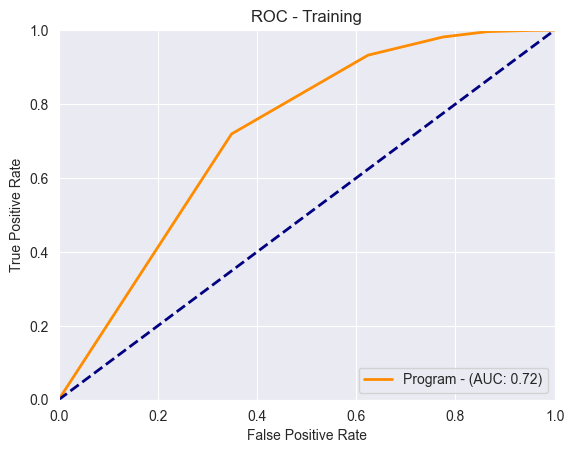

{'train_roc_auc': 0.7211791320369975,
 'train_balanced_accuracy': 0.6856686040991151,
 'train_precision': 0.7905336981358583,
 'train_recall': 0.7191799955862066,
 'train_accuracy': 0.6953274458186058,
 'train_f1': 0.7529229359840005}

In [14]:
# prg = lambda x: -x.desc2D_TPSA # AUC : 0.77, BA: 0.6764
# prg = lambda x: x["desc2D_FpDensityMorgan3"] - x["desc2D_NumHDonors"] # AUC 0.75, BA: 0.655
# prg = lambda x: x.desc2D_qed / (x.desc2D_NumHDonors**2 if x.desc2D_NumHDonors else 1) # AUC = 0.76 BA: 0.686
# prg = lambda x: x.desc2D_qed # AUC : 0.71, BA: 0.65
# prg = lambda x: (x.desc2D_Ipc - x.desc2D_NumHDonors) / (x.desc2D_Ipc if x.desc2D_Ipc else 1) # AUC 0.71, BA 0.62
# prg = lambda x: x.chemaxon_logd # AUC: 0.67, BA: 0.624
# prg = lambda x: math.sqrt(x.desc2D_BalabanJ) - x.desc2D_NumHDonors # AUC 0.73, BA 0.65
# prg = lambda x: x.chemaxon_logd / (x.desc2D_Kappa3 if x.desc2D_Kappa3 else 1) # AUC: 72, BA: 0.61
# prg = lambda x: x.desc2D_NumAliphaticHeterocycles / ((x.desc2D_Chi4n if x.desc2D_Chi4n else 1) / (x.chemaxon_logd if x.chemaxon_logd else 1))  # AUC: 0.7, BA: 0.58
# prg = lambda x: min( (x.desc2D_NumBridgeheadAtoms/ (x.desc2D_NumHDonors if x.desc2D_NumHDonors else 1)), x.chemaxon_logd )  # AUC: 0.67 BA: 0.61
# prg = lambda x: -6.5 / ((x.desc2D_TPSA if x.desc2D_TPSA else 1) / -6.5) # AUC = 0.77, BA: 0.5
# prg = lambda x: min(x.chemaxon_logd, -x.desc2D_TPSA, 1/(x.desc2D_NumHDonors**2 if x.desc2D_NumHDonors else 1)) # AUC = 0.75, BA 0.676
# prg = lambda x: math.log(abs(x.chemaxon_logd + 7.104)) - x.desc2D_NumHDonors # AUC = 0.75, BA 0.66

# prg = lambda x: max(max(x.chemaxon_logd / abs(x.chemaxon_logd if x.chemaxon_logd else 1), 1 / x.desc2D_MolWt), 1 / x.desc2D_MolWt) # AIC = 0.67, BA: 0.652
# prg = lambda x: x.chemaxon_logp * math.sqrt( abs(x.chemaxon_pka_b) / (x.desc2D_TPSA if x.desc2D_TPSA else 0.00001)) # AUC = 0.72, BA: 0.58
# prg = lambda x: - x.desc2D_NumHDonors, # AUC: 0.74, BA: 0.65
# prg = lambda x:  x.chemaxon_logd # AUC = 0.67, BA: 0.62
# prg =  lambda x: x.desc2D_BCUT2D_MRLOW - (x.desc2D_BCUT2D_CHGLO + x.desc2D_NumHDonors) # AUC: 0.76, BA: 0.652
# prg = lambda x:  (x.desc2D_BCUT2D_CHGLO + x.desc2D_NumHDonors) / x.desc2D_BCUT2D_CHGLO - x.desc2D_MaxPartialCharge # AUC: 0.75, BA: 0.658
# prg = lambda x: math.sqrt(abs(x.desc2D_BCUT2D_CHGLO)) - x.desc2D_NumHDonors # AUC: 0.75, BA: 0.654
prg = lambda x: 1 / (x.desc2D_NumHDonors if x.desc2D_NumHDonors else 1) # AUC = 0.72, BA: 0.686
prg_vals = df_train.apply(axis=1, func=prg)
fpr_prg, tpr_prg, thresholds_prg = roc_curve(df_train["BBB_numeric"], prg_vals)

plt.plot(fpr_prg, tpr_prg, color='darkorange', lw=2, label='Program - (AUC: %.2f)' % roc_auc_score(df_train["BBB_numeric"], prg_vals))
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC - Training')
plt.legend(loc="lower right")
plt.show()

_m = LogisticRegression(random_state=42)
_log_reg_res = evaluate_train(_m, pd.DataFrame([prg_vals]).T, df_train.murcko_scaffold_grouped, df_train["BBB_numeric"]) 
{k.replace("test", "train"): sum(v)/len(v) for k, v in _log_reg_res.items() if "test" in k}

# We have attempted at including the inverted NumHDonors as a feature, but it did not result in a better performance of the models.

# Derive a simple index by transforming the low-parameter logistic regression.
We start with CNS_MPO components, then simple and extended set of filtered 2D descriptors. We are interested in an explainable, well-balanced performer, limited overfitting and having a standalone calculated-only index.

In [15]:
def get_forward_selected_feature_model_performance(model_creator, X_train,  y_train, n_feat=1):
    _res = []
    for n in range(1, n_feat + 1):
        _mod = model_creator()
        sfs = SequentialFeatureSelector(estimator=_mod, n_jobs=-1, n_features_to_select=n)
        sfs.fit(X_train, y_train)
        _z = pd.Series(sfs.get_support(), index=X_train.columns)
        _fs = list(_z[_z==True].index)
        _mod = model_creator()
        _mod.fit(X_train[_fs], y_train)
        _res.append({
            "model": _mod.__class__.__name__,
            "n_feat": n,
            "bacc_train": balanced_accuracy_score(y_train, _mod.predict(X_train[_fs])),
            # "bacc_test": balanced_accuracy_score(y_test, _mod.predict(X_test[_fs])),
            "features": _fs,
        })
    return pd.DataFrame(_res)

In [16]:
_features = CNS_MPO_FEATURES + ["chemaxon_pka_b"]
df_feature_ffs_log_reg_cns_mpo = get_forward_selected_feature_model_performance(
    model_creator=lambda: LogisticRegression(max_iter=1000, random_state=42), 
    X_train= df_train[_features], 
    y_train=df_train["BBB_numeric"], 
    #X_test=df_test[_features], 
    #y_test=df_test["BBB_numeric"], 
    n_feat=6
)
df_feature_ffs_log_reg_cns_mpo

,model,n_feat,bacc_train,features
0,LogisticRegression,1,0.676734,[desc2D_TPSA]
1,LogisticRegression,2,0.696759,"[desc2D_TPSA, chemaxon_logd]"
2,LogisticRegression,3,0.703213,"[desc2D_TPSA, chemaxon_logp, chemaxon_logd]"
3,LogisticRegression,4,0.705180,"[desc2D_TPSA, desc2D_NumHDonors, chemaxon_logp..."
4,LogisticRegression,5,0.703346,"[desc2D_TPSA, desc2D_MolWt, desc2D_NumHDonors,..."
5,LogisticRegression,6,0.696897,"[desc2D_TPSA, desc2D_MolWt, desc2D_NumHDonors,..."


In [17]:
_mod = LogisticRegression(random_state=42, max_iter=1000)
_feats = ["desc2D_TPSA", "chemaxon_logd",]
_mod.fit(X=df_train[_feats], y=df_train["BBB_numeric"])
print("Best index-like set of fetures based on CNS MPO components")
print("Coefficient + intercept:", _mod.coef_, _mod.intercept_)
print("Train balanced accuracy:", balanced_accuracy_score( df_train["BBB_numeric"], _mod.predict(df_train[_feats])))
print("Test balanced accuracy:", balanced_accuracy_score( df_test["BBB_numeric"], _mod.predict(df_test[_feats])))

Best index-like set of fetures based on CNS MPO components
Coefficient + intercept: [[-0.0237057   0.12889012]] [2.1165256]
Train balanced accuracy: 0.6967592017837456
Test balanced accuracy: 0.7268004472202946


Derived, simplified index results.
Train:
  balanced accuracy: 0.7140879656758072
  ROC AUC: 0.77968481531876
  PR AUC: 0.8255808438992561
Test:
  balanced accuracy: 0.7334894749016887
  ROC AUC: 0.7771898373043411
  PR AUC: 0.7763198524256631


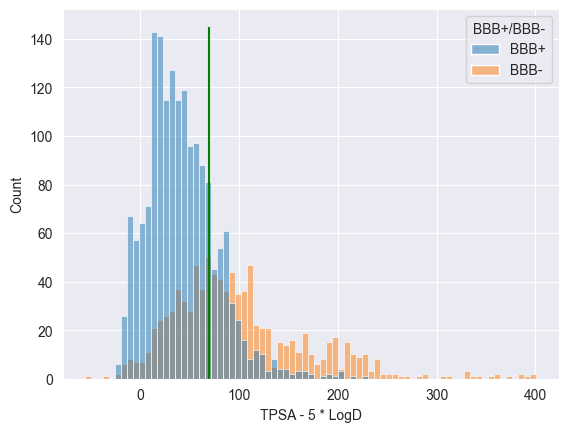

In [18]:
#ind = lambda x: (1.8 - x.desc2D_TPSA / 40 + x.chemaxon_logd / 8)
ind = lambda x: x.desc2D_TPSA - 5 * x.chemaxon_logd
print("Derived, simplified index results.")
print("Train:")
print("  balanced accuracy:", balanced_accuracy_score(df_train["BBB_numeric"], df_train.apply(axis=1, func=lambda x: ind(x) < 70)))
print("  ROC AUC:", roc_auc_score(df_train["BBB_numeric"], df_train.apply(axis=1, func=lambda x: -ind(x))))
print("  PR AUC:", pr_auc_score(df_train["BBB_numeric"], df_train.apply(axis=1, func=lambda x: -ind(x))))
print("Test:")
print("  balanced accuracy:", balanced_accuracy_score(df_test["BBB_numeric"], df_test.apply(axis=1, func=lambda x: ind(x) < 70)))
print("  ROC AUC:", roc_auc_score(df_test["BBB_numeric"], df_test.apply(axis=1, func=lambda x: -ind(x))))
print("  PR AUC:", pr_auc_score(df_test["BBB_numeric"], df_test.apply(axis=1, func=lambda x: -ind(x))))

_df = df_train.copy()
_df["ind"] = _df.apply(axis=1, func=ind)

ax = sns.histplot(_df, x="ind", hue="BBB+/BBB-", bins=75)
ax.set_xlabel("TPSA - 5 * LogD")
_ = ax.vlines(x=70.0, ymin=0, ymax=145, colors='green')

In [19]:
_features = SIMPLE_FILTERED_FEATURES
df_feature_ffs_log_reg_simple = get_forward_selected_feature_model_performance(
    model_creator=lambda: LogisticRegression(max_iter=1000, random_state=42), 
    X_train= df_train[_features], 
    y_train=df_train["BBB_numeric"], 
    n_feat=12
)
df_feature_ffs_log_reg_simple

,model,n_feat,bacc_train,features
0,LogisticRegression,1,0.676734,[desc2D_TPSA]
1,LogisticRegression,2,0.696759,"[desc2D_TPSA, chemaxon_logd]"
2,LogisticRegression,3,0.713069,"[desc2D_TPSA, chemaxon_logd, desc2D_NumAromati..."
3,LogisticRegression,4,0.721145,"[desc2D_TPSA, desc2D_NumHDonors, chemaxon_logd..."
4,LogisticRegression,5,0.724678,"[desc2D_TPSA, desc2D_NumHDonors, chemaxon_logd..."
5,LogisticRegression,6,0.725793,"[desc2D_TPSA, desc2D_NumHDonors, chemaxon_logd..."
6,LogisticRegression,7,0.725793,"[desc2D_TPSA, desc2D_NumHDonors, chemaxon_logd..."
7,LogisticRegression,8,0.725793,"[desc2D_TPSA, desc2D_NumHDonors, chemaxon_logd..."
8,LogisticRegression,9,0.727440,"[desc2D_TPSA, desc2D_NumHDonors, chemaxon_logd..."
9,LogisticRegression,10,0.728211,"[desc2D_TPSA, desc2D_NumHDonors, chemaxon_logd..."


In [20]:
_mod = LogisticRegression(random_state=42, max_iter=1000)
_feats = ["desc2D_TPSA", "chemaxon_logd", "desc2D_NumAromaticRings"] #, "desc2D_NumHDonors"]
_mod.fit(X=df_train[_feats], y=df_train["BBB_numeric"])
print("Best index-like set of fetures based on CNS MPO components")
print("Coefficient + intercept:", _mod.coef_, _mod.intercept_)
print("Train balanced accuracy:", balanced_accuracy_score( df_train["BBB_numeric"], _mod.predict(df_train[_feats])))
print("Test balanced accuracy:", balanced_accuracy_score( df_test["BBB_numeric"], _mod.predict(df_test[_feats])))

Best index-like set of fetures based on CNS MPO components
Coefficient + intercept: [[-0.02317525  0.17086702 -0.22108044]] [2.36320326]
Train balanced accuracy: 0.7130690282757457
Test balanced accuracy: 0.7388676844783715


In [21]:
_features = EXTENDED_FILTERED_FEATURES
df_feature_ffs_log_reg_extended = get_forward_selected_feature_model_performance(
    model_creator=lambda: LogisticRegression(max_iter=1000, random_state=42), 
    X_train= df_train[_features], 
    y_train=df_train["BBB_numeric"], 
    n_feat=12
)
df_feature_ffs_log_reg_extended

,model,n_feat,bacc_train,features
0,LogisticRegression,1,0.676734,[desc2D_TPSA]
1,LogisticRegression,2,0.713361,"[desc2D_TPSA, desc2D_fr_ketone_Topliss]"
2,LogisticRegression,3,0.717028,"[desc2D_TPSA, desc2D_VSA_EState3, desc2D_fr_ke..."
3,LogisticRegression,4,0.726008,"[desc2D_TPSA, desc2D_VSA_EState3, desc2D_fr_ke..."
4,LogisticRegression,5,0.733662,"[desc2D_TPSA, desc2D_VSA_EState3, desc2D_fr_CO..."
5,LogisticRegression,6,0.747051,"[desc2D_TPSA, desc2D_NumSaturatedRings, desc2D..."
6,LogisticRegression,7,0.749176,"[desc2D_TPSA, desc2D_NumSaturatedRings, desc2D..."
7,LogisticRegression,8,0.749760,"[desc2D_TPSA, desc2D_NumSaturatedRings, desc2D..."
8,LogisticRegression,9,0.749521,"[desc2D_TPSA, desc2D_NumSaturatedRings, desc2D..."
9,LogisticRegression,10,0.748750,"[desc2D_TPSA, desc2D_NumSaturatedRings, desc2D..."


In [22]:
_mod = LogisticRegression(random_state=42, max_iter=1000)
_feats = ["desc2D_TPSA", "desc2D_VSA_EState3", "desc2D_fr_ketone_Topliss"]
_mod.fit(X=df_train[_feats], y=df_train["BBB_numeric"])
print("Best index-like set of fetures based on CNS MPO components")
print("Coefficient + intercept:", _mod.coef_, _mod.intercept_)
print("Train balanced accuracy:", balanced_accuracy_score( df_train["BBB_numeric"], _mod.predict(df_train[_feats])))
print("Test balanced accuracy:", balanced_accuracy_score( df_test["BBB_numeric"], _mod.predict(df_test[_feats])))

Best index-like set of fetures based on CNS MPO components
Coefficient + intercept: [[-0.02490566 -0.02612565  1.04688084]] [2.51116918]
Train balanced accuracy: 0.7170277692254213
Test balanced accuracy: 0.7223667977484771


In [23]:
print("Results for the inclusion of MACCS, discarded due to poorer interpretability of the results.")
_features = EXTENDED_FILTERED_FEATURES + list(df_train_features_maccs)
df_feature_ffs_log_reg_extended_maccs = get_forward_selected_feature_model_performance(
    model_creator=lambda: LogisticRegression(max_iter=1000, random_state=42), 
    X_train= df_train[_features], 
    y_train=df_train["BBB_numeric"],  
    n_feat=5
)
df_feature_ffs_log_reg_extended_maccs

Results for the inclusion of MACCS, discarded due to poorer interpretability of the results.


,model,n_feat,bacc_train,features
0,LogisticRegression,1,0.676734,[desc2D_TPSA]
1,LogisticRegression,2,0.723136,"[desc2D_TPSA, maccs_fp_26]"
2,LogisticRegression,3,0.732198,"[desc2D_TPSA, desc2D_fr_quatN, maccs_fp_26]"
3,LogisticRegression,4,0.737722,"[desc2D_TPSA, desc2D_fr_quatN, maccs_fp_23, ma..."
4,LogisticRegression,5,0.744873,"[desc2D_TPSA, desc2D_fr_COO2, desc2D_fr_quatN,..."


In [24]:
# df_feature_ffs_rf = get_forward_selected_feature_model_performance(
#     model_creator=lambda: RandomForestClassifier(random_state=42), 
#     X_train= df_train_features_desc2D_chemaxon_filtered, 
#     y_train=df_train["BBB_numeric"], 
#     X_test=df_test, 
#     y_test=df_test["BBB_numeric"], 
#     n_feat=25
# )
# df_feature_ffs_rf

In [25]:
# We have investigated if removal of potential outliers has an effect on the results and helps with overfitting. We have not identified any improvement in the algorithm - feature space screening. 
# from sklearn.ensemble import IsolationForest
# iso_forest = IsolationForest(contamination=0.01)
# iso_forest.fit(df_train_features)
# outlier_predictions = iso_forest.predict(df_train_features)
# df_train_pruned = df_train.loc[outlier_predictions == 1]
# print(f"Removed {len(df_train) - len(df_train_pruned)} (out of {len(df_train)} ) training samples based on IsolationForest")

# Performance of algorithms

In [26]:
import copy
_results = []
for m in [
    LogisticRegression(max_iter=1000, random_state=42),
    XGBClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
]:
    for _fsn, _feats in [
        ("CNS MPO", CNS_MPO_FEATURES),
        ("2D Simple", SIMPLE_FILTERED_FEATURES),
        ("2D Extended", EXTENDED_FILTERED_FEATURES),
        ("MACCS", list(df_train_features_maccs)),
        ("ECFP-count", list(df_train_features_ecfp_count)),
        ("2D Simple + MACCS", SIMPLE_FILTERED_FEATURES + list(df_train_features_maccs)),
        ("2D Extended + MACCS", EXTENDED_FILTERED_FEATURES + list(df_train_features_maccs)),
        ("2D Extended + MACCS + ECFP-count", EXTENDED_FILTERED_FEATURES + list(df_train_features_maccs) + list(df_train_features_ecfp_count)),
    ]:
        _r_tr = evaluate_train(copy.deepcopy(m), df_train[_feats], df_train.murcko_scaffold_grouped, df_train["BBB_numeric"])
        _r_te = evaluate_test(
            copy.deepcopy(m).fit(df_train[_feats], df_train["BBB_numeric"]), 
            X_test=df_test[_feats],
            y_test=df_test["BBB_numeric"]
        )
        
        # _r_trp = evaluate_train(copy.deepcopy(m), df_train_pruned[_feats], df_train_pruned.murcko_scaffold_grouped, df_train_pruned["BBB_numeric"])
        # _r_tep = evaluate_test(copy.deepcopy(m).fit(df_train_pruned[_feats], df_train_pruned["BBB_numeric"]), X_test=df_test[_feats], y_test=df_test["BBB_numeric"])
        _results.append({
            "model": m.__class__.__name__,
            "feature_set": _fsn,
            "train_roc_auc": sum(_r_tr["test_roc_auc"]) / len(_r_tr["test_roc_auc"]),
            "train_b_acc": sum(_r_tr["test_balanced_accuracy"]) / len(_r_tr["test_balanced_accuracy"]),
            #"test_roc_auc": _r_te["roc_auc"],
            #"test_b_acc": _r_te["balanced_accuracy"],
            #"raw_train_roc_auc": _r_tr["test_roc_auc"],
            #"raw_train_b_acc": _r_tr["test_balanced_accuracy"],
            # "pruned_train_roc_auc": sum(_r_trp["test_roc_auc"]) / len(_r_trp["test_roc_auc"]),
            # "pruned_train_b_acc": sum(_r_trp["test_balanced_accuracy"]) / len(_r_trp["test_balanced_accuracy"]),
            # "pruned_test_roc_auc": _r_tep["roc_auc"],
            # "pruned_test_b_acc": _r_tep["balanced_accuracy"],
        })
        
df_algo_results = pd.DataFrame(_results)
df_algo_results


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

,model,feature_set,train_roc_auc,train_b_acc
0,LogisticRegression,CNS MPO,0.795459,0.698048
1,LogisticRegression,2D Simple,0.840207,0.750298
2,LogisticRegression,2D Extended,0.874824,0.782361
3,LogisticRegression,MACCS,0.853860,0.769930
4,LogisticRegression,ECFP-count,0.886614,0.799513
5,LogisticRegression,2D Simple + MACCS,0.872623,0.784697
6,LogisticRegression,2D Extended + MACCS,0.880457,0.791366
7,LogisticRegression,2D Extended + MACCS + ECFP-count,0.891790,0.802957
8,XGBClassifier,CNS MPO,0.860864,0.774765
9,XGBClassifier,2D Simple,0.906553,0.817700


In [27]:

# sm = SVMSMOTE(random_state=42) 
# df_train_oversampled, y_train_oversampled = X_res, y_res = sm.fit_resample(df_train, df_train[])



In [28]:
import copy
from imblearn.over_sampling import SVMSMOTE, SMOTE

_results = []
for m in [
    LogisticRegression(max_iter=1000, random_state=42),
    XGBClassifier(random_state=42),
    RandomForestClassifier(random_state=42),
    #GaussianProcessClassifier(n_jobs=-1, random_state=42)
]:
    for _fsn, _feats in [
        ("CNS MPO", CNS_MPO_FEATURES),
        ("2D Simple", SIMPLE_FILTERED_FEATURES),
        ("2D Extended", EXTENDED_FILTERED_FEATURES),
        ("MACCS", list(df_train_features_maccs)),
        ("ECFP-count", list(df_train_features_ecfp_count)),
        ("2D Simple + MACCS", SIMPLE_FILTERED_FEATURES + list(df_train_features_maccs)),
        ("2D Extended + MACCS", EXTENDED_FILTERED_FEATURES + list(df_train_features_maccs)),
        ("2D Extended + MACCS + ECFP-count", EXTENDED_FILTERED_FEATURES + list(df_train_features_maccs) + list(df_train_features_ecfp_count)),
    ]:  
        
        # _r_tr = evaluate_train(copy.deepcopy(m), df_train[_feats], df_train.murcko_scaffold_grouped, df_train["BBB_numeric"])
        
        # We are getting somewhat changed but not considerably improved results when using SMOTE or SVMSMOTE for oversampling.
        sm = SMOTE(random_state=42)
        X_os, y_os = sm.fit_resample(df_train[_feats], df_train["BBB_numeric"])
        _r_te = evaluate_test(copy.deepcopy(m).fit(X_os, y_os), X_test=df_test[_feats], y_test=df_test["BBB_numeric"])
        
        # Using a scaler degrades testing results (easily possible with boosted models, but this issue includes regression).
        #scaler = StandardScaler()
        #scaler.fit(df_train[_feats])
        
        
        # _r_trp = evaluate_train(copy.deepcopy(m), df_train_pruned[_feats], df_train_pruned.murcko_scaffold_grouped, df_train_pruned["BBB_numeric"])
        # _r_tep = evaluate_test(copy.deepcopy(m).fit(df_train_pruned[_feats], df_train_pruned["BBB_numeric"]), X_test=df_test[_feats], y_test=df_test["BBB_numeric"])
        _results.append({
            "model": m.__class__.__name__,
            "feature_set": _fsn,
            #"train_roc_auc": sum(_r_tr["test_roc_auc"]) / len(_r_tr["test_roc_auc"]),
            #"train_b_acc": sum(_r_tr["test_balanced_accuracy"]) / len(_r_tr["test_balanced_accuracy"]),
            "test_roc_auc": _r_te["roc_auc"],
            "test_b_acc": _r_te["balanced_accuracy"],
            #"raw_train_roc_auc": _r_tr["test_roc_auc"],
            #"raw_train_b_acc": _r_tr["test_balanced_accuracy"],
            # "pruned_train_roc_auc": sum(_r_trp["test_roc_auc"]) / len(_r_trp["test_roc_auc"]),
            # "pruned_train_b_acc": sum(_r_trp["test_balanced_accuracy"]) / len(_r_trp["test_balanced_accuracy"]),
            # "pruned_test_roc_auc": _r_tep["roc_auc"],
            # "pruned_test_b_acc": _r_tep["balanced_accuracy"],
        })
        
df_algo_results = pd.DataFrame(_results)
df_algo_results


/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/opt/homebrew/lib/python3.11/site-packages/sklearn/linear_model/_logistic.py:469: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_

,model,feature_set,test_roc_auc,test_b_acc
0,LogisticRegression,CNS MPO,0.804635,0.742415
1,LogisticRegression,2D Simple,0.833656,0.750810
2,LogisticRegression,2D Extended,0.855863,0.759118
3,LogisticRegression,MACCS,0.844336,0.771831
4,LogisticRegression,ECFP-count,0.868643,0.788216
5,LogisticRegression,2D Simple + MACCS,0.856480,0.780698
6,LogisticRegression,2D Extended + MACCS,0.838369,0.768014
7,LogisticRegression,2D Extended + MACCS + ECFP-count,0.870668,0.801575
8,XGBClassifier,CNS MPO,0.852393,0.778732
9,XGBClassifier,2D Simple,0.892470,0.806037


## XGBoost classifier - development

In [159]:
_fs = SIMPLE_FILTERED_FEATURES
m_class = XGBClassifier(random_state=42)
m_class.fit(df_train[_fs], df_train["BBB_numeric"])
evaluate_test(m_class, df_test[_fs], df_test["BBB_numeric"])

{'roc_auc': 0.8916599198087748,
 'pr_auc': 0.9231928244743046,
 'balanced_accuracy': 0.8103554630272187,
 'accuracy': 0.8191489361702128}

In [272]:
from sklearn.model_selection import cross_val_score

m_class = XGBClassifier(random_state = 42)
# Features from SIMPLE_FILTERED_FEATURES and MACCS fingerprings have been iteratively eliminated based on the guided by feature importance.
#fs_reg = SIMPLE_FILTERED_FEATURES + list(df_train_features_maccs)


fs_class = [f for f in SIMPLE_FILTERED_FEATURES if f not in {
    "desc2D_NumSpiroAtoms",
    "desc2D_NumAtomStereoCenters",
    "desc2D_NumUnspecifiedAtomStereoCenters",
    "desc2D_NumRadicalElectrons",
}]

r = evaluate_train(copy.deepcopy(m_class), X_train=df_train[fs_class], X_groups=df_train.murcko_scaffold_grouped, y_train=df_train.BBB_numeric)
print("Training 5-cross CV")
print("  B.Accuracy:", sum(_r_tr["test_balanced_accuracy"]) / len(_r_tr["test_balanced_accuracy"]))

print("  ROC AUC:", sum(_r_tr["test_roc_auc"]) / len(_r_tr["test_roc_auc"]))

m_class.fit(
    df_train[fs_class], 
    df_train.BBB_numeric
)

print("Test:")
y_te_p = m_class.predict(df_test[fs_class])
y_te_prob = m_class.predict_proba(df_test[fs_class])[:, 1]
print("  B.Acc  :", balanced_accuracy_score(df_test["BBB_numeric"], y_te_p))
print("  ROC AUC:", roc_auc_score(df_test["BBB_numeric"], y_te_prob))
print("  PR AUC:", pr_auc_score(df_test["BBB_numeric"], y_te_p))

print("Model feature importances: ")
pd.Series(m_class.feature_importances_, index=fs_class).sort_values(ascending=False)

Training 5-cross CV
  B.Accuracy: 0.8175037999109973
  ROC AUC: 0.92916436076805
Test:
  B.Acc  : 0.8103554630272187
  ROC AUC: 0.8916599198087748
  PR AUC: 0.894399522339052
Model feature importances: 


desc2D_TPSA                        0.139102
desc2D_NumSaturatedHeterocycles    0.059442
desc2D_NumBridgeheadAtoms          0.050227
desc2D_NumAromaticRings            0.048909
chemaxon_logd                      0.048523
desc2D_NumHDonors                  0.042510
desc2D_MaxEStateIndex              0.042278
desc2D_NumAmideBonds               0.041542
desc2D_qed                         0.039753
desc2D_Chi4v                       0.037246
chemaxon_pka_b                     0.036037
chemaxon_logp                      0.034752
desc2D_NumAromaticHeterocycles     0.034550
desc2D_MinPartialCharge            0.032668
desc2D_MaxPartialCharge            0.030337
desc2D_FractionCSP3                0.029498
desc2D_NumHAcceptors               0.027767
desc2D_BalabanJ                    0.027738
desc2D_Kappa3                      0.027615
desc2D_NumRotatableBonds           0.026923
desc2D_MinEStateIndex              0.025950
desc2D_RingCount                   0.025095
desc2D_HeavyAtomCount           

In [273]:
# Establish a validation dataset for hyperparameter optimisation.
from twinning import twinning

g_scaffold_desc_for_split_mean = df_train[fs_class + ["murcko_scaffold_grouped"]].groupby("murcko_scaffold_grouped").mean()
_s_validation_scaffolds = set(g_scaffold_desc_for_split_mean.index[twinning.twin(g_scaffold_desc_for_split_mean.to_numpy(), r=5, u1=42)])
print(f"{len(_s_validation_scaffolds)}/{len(g_scaffold_desc_for_split_mean)} (grouped) Murcko scaffolds assigned to the validation set.")

df_train_validation = df_train[df_train.murcko_scaffold_grouped.apply(lambda x: x in _s_validation_scaffolds)]
df_train_sans_validation = df_train[df_train.murcko_scaffold_grouped.apply(lambda x: x not in _s_validation_scaffolds)]
print(f"Training set is separated into a dedicated validation (N={len(df_train_validation)}), with the remaining datapoints in training sans validation set (N={len(df_train_sans_validation)}) ")

328/1638 (grouped) Murcko scaffolds assigned to the validation set.
Training set is separated into a dedicated validation (N=529), with the remaining datapoints in training sans validation set (N=2124) 


In [300]:
import os
from hyperopt import hp, STATUS_OK, Trials, fmin, tpe
import pprint

# Optimisation.

xgb_optimisation_space = {
    'max_depth': hp.uniformint("max_depth", 1, 5),
    'gamma': hp.uniform ('gamma', 1, 4),
    'reg_alpha' : hp.uniform('reg_alpha', 0, 2),
    'reg_lambda' : hp.uniform('reg_lambda', 0, 2),
    'colsample_bytree' : hp.uniform('colsample_bytree', 0.1, 1),
    'n_estimators/10': hp.uniformint("n_estimators/10", 1, 20),
    'seed': 42
}

def objective(space):
    _m = XGBClassifier(
        random_state = 42,
        early_stopping_rounds=10, 
        eval_metric="aucpr", #"rmse",
        n_estimators=space['n_estimators/10'] * 10, 
        max_depth = (space['max_depth']), 
        gamma = space['gamma'],
        reg_alpha = space["reg_alpha"],
        reg_lambda = space["reg_lambda"],
        colsample_bytree=space['colsample_bytree'],
    ).fit(
        df_train_sans_validation[fs_class], 
        df_train_sans_validation.BBB_numeric,
        eval_set=[(df_train_sans_validation[fs_class], df_train_sans_validation.BBB_numeric), (df_train_validation[fs_class], df_train_validation.BBB_numeric)], 
        verbose=False
    )    
    p_test = _m.predict(df_train_validation[fs_class])
    return {'loss': balanced_accuracy_score(df_train_validation.BBB_numeric, p_test), 'status': STATUS_OK}

trials = Trials()

os.environ["HYPEROPT_FMIN_SEED"] = "42" 
reg_top_hyperparams = fmin(
    fn = objective,
    space = xgb_optimisation_space,
    algo = tpe.suggest,
    max_evals = 100,
    trials = trials,
)
print("Optimisation - best hyperparameters:")
pprint.pprint(reg_top_hyperparams)

m_class_opt = XGBClassifier(
    random_state = 42,
    #early_stopping_rounds=10, 
    #eval_metric="rmse",
    # n_estimators=int(reg_top_hyperparams["n_estimators/10"]) * 10,
    # max_depth=int(reg_top_hyperparams["max_depth"]),
    # gamma=reg_top_hyperparams["gamma"],
    # reg_alpha = reg_top_hyperparams["reg_alpha"],
    # reg_lambda = reg_top_hyperparams["reg_lambda"],
    # colsample_bytree=reg_top_hyperparams["colsample_bytree"],
).fit(
    df_train_sans_validation[fs_class], 
    df_train_sans_validation.BBB_numeric,
    eval_set=[(df_train_sans_validation[fs_class], df_train_sans_validation.BBB_numeric), (df_train_validation[fs_class], df_train_validation.BBB_numeric)], 
    verbose=False
)
y_val_p_opt = m_class_opt.predict(df_train_validation[fs_class])
y_val_opt_prob = m_class.predict_proba(df_train_validation[fs_class])[:, 1]
print("Post-optimisation validation stats:")
print("  B.Acc  :", balanced_accuracy_score(df_train_validation["BBB_numeric"], y_val_p_opt))
print("  ROC AUC:", roc_auc_score(df_train_validation["BBB_numeric"], y_val_opt_prob))
print("  PR AUC:", pr_auc_score(df_train_validation["BBB_numeric"], y_val_p_opt))

print("Post-optimisation test stat :")
y_te_p = m_class_opt.predict(df_test[fs_class])
y_te_prob = m_class_opt.predict_proba(df_test[fs_class])[:, 1]
print("  B.Acc  :", balanced_accuracy_score(df_test["BBB_numeric"], y_te_p))
print("  ROC AUC:", roc_auc_score(df_test["BBB_numeric"], y_te_prob))
print("  PR AUC:", pr_auc_score(df_test["BBB_numeric"], y_te_p))

100%|██████████| 100/100 [00:04<00:00, 21.38trial/s, best loss: 0.7065012664804833]
Optimisation - best hyperparameters:
{'colsample_bytree': 0.46631681660975055,
 'gamma': 1.3218524060563934,
 'max_depth': 1.0,
 'n_estimators/10': 1.0,
 'reg_alpha': 1.0206345608155307,
 'reg_lambda': 0.6170701570175221}
Post-optimisation validation stats:
  B.Acc  : 0.8379635643307137
  ROC AUC: 0.9198545171137236
  PR AUC: 0.9297503123033052
Post-optimisation test stat :
  B.Acc  : 0.7869245894055055
  ROC AUC: 0.8749903616315831
  PR AUC: 0.8813409331721822


In [410]:
m_class_final = XGBClassifier(random_state=42).fit(df_train[fs_class], df_train["BBB_numeric"])
print("Final classification model features:")
pprint.pprint(fs_class)
classification_model_file = "final_classification_model.pkl"
print(f"Saving final model to {classification_model_file}")
with open(classification_model_file, 'wb') as file:
    pickle.dump(m_class_final, file)

Final classification model features:
['desc2D_TPSA',
 'desc2D_NumHDonors',
 'chemaxon_logp',
 'chemaxon_logd',
 'chemaxon_pka_b',
 'desc2D_NumHAcceptors',
 'desc2D_HeavyAtomCount',
 'desc2D_MinPartialCharge',
 'desc2D_MaxPartialCharge',
 'desc2D_qed',
 'desc2D_MinEStateIndex',
 'desc2D_HallKierAlpha',
 'desc2D_MaxEStateIndex',
 'desc2D_Kappa3',
 'desc2D_Ipc',
 'desc2D_FractionCSP3',
 'desc2D_NumSaturatedHeterocycles',
 'desc2D_Chi4v',
 'desc2D_MinAbsEStateIndex',
 'desc2D_NumRotatableBonds',
 'desc2D_BalabanJ',
 'desc2D_RingCount',
 'desc2D_NumAmideBonds',
 'desc2D_NumAromaticHeterocycles',
 'desc2D_NumSaturatedRings',
 'desc2D_NumBridgeheadAtoms',
 'desc2D_NumAromaticRings']
Saving final model to final_classification_model.pkl


In [401]:
## This assumes the regression model is built and pickled.
import pickle
with open('final_regression_model.pkl', 'rb') as file:
    m_reg = pickle.load(file)

fs_reg = [
    "chemaxon_logd",
    "chemaxon_pka_b",
    "desc2D_TPSA",
    "desc2D_NumHAcceptors",
    "desc2D_MinPartialCharge",
    "desc2D_NumRotatableBonds",
    "desc2D_MinEStateIndex",
    "desc2D_MaxEStateIndex",
    "desc2D_MolWt",
]
pr_lbb = "predicted_logBB"

df_train[pr_lbb] = m_reg.predict(df_train[fs_reg])
df_test[pr_lbb] = m_reg.predict(df_test[fs_reg])

In [406]:
def _rethreshold(x, threshold = -1):
    return x["BBB+/BBB-"] == "BBB+" if pd.isna(x.logBB) else x.logBB >= threshold    
BBB_num_adj = "BBB_numeric_adj" 
df_train[BBB_num_adj] = df_train.apply(axis=1, func=_rethreshold)
df_test[BBB_num_adj] = df_test.apply(axis=1, func=_rethreshold)

_m = XGBClassifier(random_state=42)
_m.fit(df_train[fs_class], df_train[BBB_num_adj])
print("Base model performance:")
pprint.pprint(evaluate_test(_m, df_test[fs_class], df_test[BBB_num_adj]))
print("-"*50)
print("Model augmented with predicted logBB values:")
_m = XGBClassifier(random_state=42)
_m.fit(df_train[fs_class + [pr_lbb]], df_train[BBB_num_adj])
pprint.pprint(evaluate_test(_m, df_test[fs_class + [pr_lbb]], df_test[BBB_num_adj]))
# _y_test_class_probs = m_class.predict_proba(df_test[_fs])[:, 1]
# print(roc_auc_score(df_test["BBB_numeric"], _y_test_class_probs))
# print(bala)

Base model performance:
{'accuracy': 0.8191489361702128,
 'balanced_accuracy': 0.8103554630272187,
 'pr_auc': 0.9231928244743046,
 'roc_auc': 0.8916599198087748}
--------------------------------------------------
Model augmented with predicted logBB values:
{'accuracy': 0.8069908814589666,
 'balanced_accuracy': 0.7989629115583314,
 'pr_auc': 0.9066308414943266,
 'roc_auc': 0.8814336109183438}


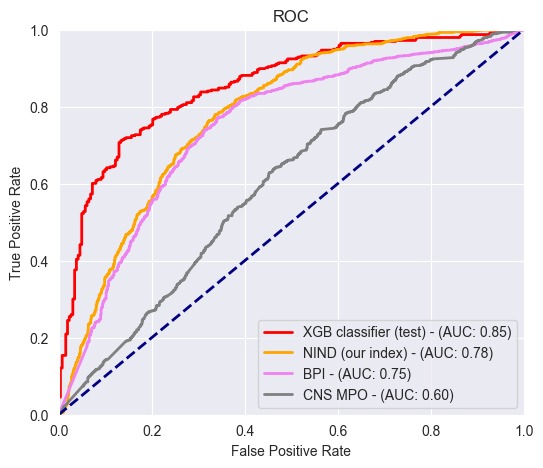

In [407]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt

from azure_stallion.utils import calculate_cns_mpo_score_wager_2010, calculate_balanced_permeability_index_weiss_2024
# Sample data: `y_true` should be your actual binary labels, `y_scores` should be the scores from your function
y_true = df_train["BBB_numeric"] 

# Plotting the ROC curve
plt.figure(figsize=(6, 5))

# fpr_tpsa, tpr_tpsa, thresholds_tpsa = roc_curve(y_true, -df_train.desc2D_TPSA)
# plt.plot(fpr_tpsa, tpr_tpsa, color='darkgreen', lw=2, label='↓TPSA (AUC: %.2f)' % roc_auc_score(y_true, -df_train.desc2D_TPSA))

fpr_xgb, tpr_xgb, thresholds_xgd = roc_curve(df_test["BBB_numeric"], _y_test_class_probs)
plt.plot(fpr_xgb, tpr_xgb, color="red", lw=2, label="XGB classifier (test) - (AUC: %.2f)" % roc_auc_score(df_test["BBB_numeric"], _y_test_class_probs))



y_scores_nind = df_train.apply(axis=1, func=lambda x: x.desc2D_TPSA - 6 * x.chemaxon_logd)
fpr_nind, tpr_nind, thresholds_nind = roc_curve(y_true, -y_scores_nind)
plt.plot(fpr_nind, tpr_nind, color="orange", lw=2, label="NIND (our index) - (AUC: %.2f)" % roc_auc_score(y_true, -y_scores_nind))

y_scores_bpi = df_train.apply(axis=1, func=lambda x: calculate_balanced_permeability_index_weiss_2024(
    c_log_d=x["chemaxon_logd"], 
    psa=x["desc2D_TPSA"] if x["desc2D_TPSA"] >= 3.24  else 3.24,  # 3.24 is the lowest value above 0. 
    hac=x["desc2D_HeavyAtomCount"]) 
).apply(lambda x: -5 if x < -5 else 5 if x > 5 else x)


fpr_bpi, tpr_bpi, thresholds_bpi = roc_curve(y_true, y_scores_bpi)
plt.plot(fpr_bpi, tpr_bpi, color='violet', lw=2, label='BPI - (AUC: %.2f)' % roc_auc_score(y_true, y_scores_bpi))


# fpr_logd, tpr_logd, thresholds_logd = roc_curve(y_true, df_train.chemaxon_logd)
# plt.plot(fpr_logd, tpr_logd, color='teal', lw=2, label='LogD - (AUC: %.2f)' % roc_auc_score(y_true, df_train.chemaxon_logd))

# fpr_mw, tpr_mw, thresholds_mw= roc_curve(y_true, -df_train.desc2D_MolWt)
# plt.plot(fpr_mw, tpr_mw, color='darkred', lw=2, label='↓MW (AUC: %.2f)' % roc_auc_score(y_true, -df_train.desc2D_MolWt))

y_scores_cns_mpo = df_train.apply(axis=1, func=lambda x: calculate_cns_mpo_score_wager_2010(
    c_log_p=x.chemaxon_logp, 
    c_log_d=x.chemaxon_logd, 
    mw=x.desc2D_MolWt, 
    tpsa=x.desc2D_TPSA, 
    hbd=x.desc2D_NumHDonors, 
    pka=x.chemaxon_pka_b))  # Example scores from your function
fpr_cns_mpo, tpr_cns_mpo, thresholds_cns_mpo = roc_curve(y_true, y_scores_cns_mpo)
plt.plot(fpr_cns_mpo, tpr_cns_mpo, color='grey', lw=2, label='CNS MPO - (AUC: %.2f)' % roc_auc_score(y_true, y_scores_cns_mpo))

plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.ylim([0, 1])
plt.xlim([0, 1])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()